In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
# Data preprocessing
# import train and test to DataFrame
import pandas as pd
train = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
test = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")
# 輸出訓練資料的資料量
print('train shape:', train.shape) 
# 輸出測試資料的資料量
print('test shape:', test.shape) 

train shape: (1460, 81)
test shape: (1459, 80)


* train shape: (1460, 81)
    * 80 features+ SalePrice (one label)
* test shape: (1459, 80)
    * 80 features, without SalePrice (need to predict)

In [3]:
# 輸出訓練資料的資訊
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

- Non-Null Count are not all 1460 non-null
- 有missing values

       price  log(price + 1)
0     208500       12.247699
1     181500       12.109016
2     223500       12.317171
3     140000       11.849405
4     250000       12.429220
...      ...             ...
1455  175000       12.072547
1456  210000       12.254868
1457  266500       12.493133
1458  142125       11.864469
1459  147500       11.901590

[1460 rows x 2 columns] 

price skew : 1.880940746034036
log(price+1) skew: 0.12122191311528363


array([[<AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'log(price + 1)'}>]], dtype=object)

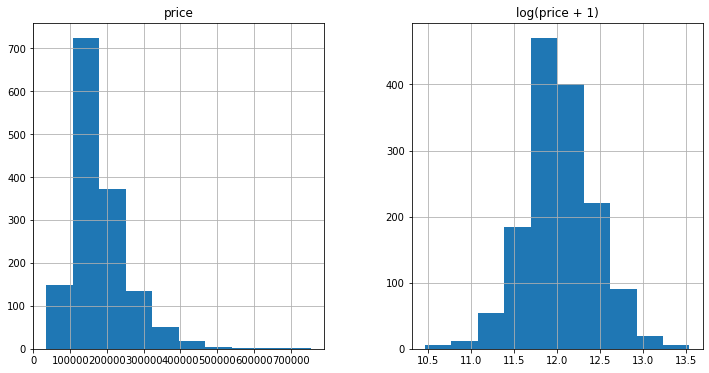

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew
%matplotlib inline

#房屋銷售價格分布狀態偏低價位，透過對數轉換，讓資料分布趨近常態分佈
# 對SalePrice+1後執行以e為底數的對數變換
# 將原始值一同登錄至資料框架中
prices = pd.DataFrame({'price':train['SalePrice'],
    'log(price + 1)':np.log1p(train['SalePrice'])})
# log1p :=  log(x+1) 　　即 ln(x+1)
#使用Numpy的np.log1p(x)，以e為底數的x+1對數，來進行對數轉換
#由於房價通常不是負數，但可能為0，所以使用np.log1p(x)來解決log(0)的問題

print(prices, '\n')
# 輸出對數變換後的'price'的偏度
print('price skew :', skew(prices['price']))
print('log(price+1) skew:', skew(prices['log(price + 1)']))
# 將變換前與變換後的"SalePrice"做成直方圖
# 設定描繪圖型的尺寸
plt.rcParams['figure.figsize'] = (12.0, 6.0)
prices.hist()

- price skew : 1.880940746034036

- log(price+1) skew: 0.12122191311528363
-skewness用來判斷分佈呈現不對稱性的程度，越接近為零就表示呈現的樣貌越接近左右對稱的常態分佈

In [5]:
#將SalePrice轉換成以e為底數的x+1對數然後存回去
train["SalePrice"] = np.log1p(train["SalePrice"])
print(train["SalePrice"])

0       12.247699
1       12.109016
2       12.317171
3       11.849405
4       12.429220
          ...    
1455    12.072547
1456    12.254868
1457    12.493133
1458    11.864469
1459    11.901590
Name: SalePrice, Length: 1460, dtype: float64


In [6]:
#在預處理中，不需要id.SalePrice這兩行，排除這兩行進行連結，這樣可以一次完成資料預處理
#loc用index的標籤來取出資料
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))
# 輸出完成連結的資料
print(all_data.shape)
print(all_data)

(2919, 79)
      MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0             60       RL         65.0     8450   Pave   NaN      Reg   
1             20       RL         80.0     9600   Pave   NaN      Reg   
2             60       RL         68.0    11250   Pave   NaN      IR1   
3             70       RL         60.0     9550   Pave   NaN      IR1   
4             60       RL         84.0    14260   Pave   NaN      IR1   
...          ...      ...          ...      ...    ...   ...      ...   
1454         160       RM         21.0     1936   Pave   NaN      Reg   
1455         160       RM         21.0     1894   Pave   NaN      Reg   
1456          20       RL        160.0    20000   Pave   NaN      Reg   
1457          85       RL         62.0    10441   Pave   NaN      Reg   
1458          60       RL         74.0     9627   Pave   NaN      Reg   

     LandContour Utilities LotConfig  ... ScreenPorch PoolArea PoolQC  Fence  \
0            Lvl    AllPub    In

In [7]:
#if skewness>0.75就進行對數轉換

from scipy.stats import skew
# 取得非object類型的欄的index
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
print('-----Column of non-object type-----')
print(numeric_feats)

-----Column of non-object type-----
Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')


In [8]:
# 除以缺漏值，求出非object類型的欄的偏度
#dropna()方法-丢弃含空值的行、列
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna()))
print('-----Skewness of non-object type column-----')
print(skewed_feats)

-----Skewness of non-object type column-----
MSSubClass        1.406210
LotFrontage       2.160866
LotArea          12.195142
OverallQual       0.216721
OverallCond       0.692355
YearBuilt        -0.612831
YearRemodAdd     -0.503044
MasVnrArea        2.666326
BsmtFinSF1        1.683771
BsmtFinSF2        4.250888
BsmtUnfSF         0.919323
TotalBsmtSF       1.522688
1stFlrSF          1.375342
2ndFlrSF          0.812194
LowQualFinSF      9.002080
GrLivArea         1.365156
BsmtFullBath      0.595454
BsmtHalfBath      4.099186
FullBath          0.036524
HalfBath          0.675203
BedroomAbvGr      0.211572
KitchenAbvGr      4.483784
TotRmsAbvGrd      0.675646
Fireplaces        0.648898
GarageYrBlt      -0.648708
GarageCars       -0.342197
GarageArea        0.179796
WoodDeckSF        1.539792
OpenPorchSF       2.361912
EnclosedPorch     3.086696
3SsnPorch        10.293752
ScreenPorch       4.117977
PoolArea         14.813135
MiscVal          24.451640
MoSold            0.211835
YrSold    

In [9]:
# 僅將偏度大於 0.75 的欄再帶入skewed_feats 
skewed_feats = skewed_feats[skewed_feats > 0.75]
print('-----Skewness greater than 0.75-----')
print(skewed_feats)

-----Skewness greater than 0.75-----
MSSubClass        1.406210
LotFrontage       2.160866
LotArea          12.195142
MasVnrArea        2.666326
BsmtFinSF1        1.683771
BsmtFinSF2        4.250888
BsmtUnfSF         0.919323
TotalBsmtSF       1.522688
1stFlrSF          1.375342
2ndFlrSF          0.812194
LowQualFinSF      9.002080
GrLivArea         1.365156
BsmtHalfBath      4.099186
KitchenAbvGr      4.483784
WoodDeckSF        1.539792
OpenPorchSF       2.361912
EnclosedPorch     3.086696
3SsnPorch        10.293752
ScreenPorch       4.117977
PoolArea         14.813135
MiscVal          24.451640
dtype: float64


In [10]:
# 取得所選出的欄的index
skewed_feats = skewed_feats.index
# 將偏度大於0.75的欄進行對數變換
all_data[skewed_feats] = np.log1p(all_data[skewed_feats])
all_data[skewed_feats] # 對偏度大於0.75 的欄執行對數變換後，進行輸出

,MSSubClass,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,...,GrLivArea,BsmtHalfBath,KitchenAbvGr,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
0,4.110874,4.189655,9.042040,5.283204,6.561031,0.0,5.017280,6.753438,6.753438,6.751101,...,7.444833,0.000000,0.693147,0.000000,4.127134,0.000000,0.0,0.0,0.0,0.000000
1,3.044522,4.394449,9.169623,0.000000,6.886532,0.0,5.652489,7.141245,7.141245,0.000000,...,7.141245,0.693147,0.693147,5.700444,0.000000,0.000000,0.0,0.0,0.0,0.000000
2,4.110874,4.234107,9.328212,5.093750,6.188264,0.0,6.075346,6.825460,6.825460,6.765039,...,7.488294,0.000000,0.693147,0.000000,3.761200,0.000000,0.0,0.0,0.0,0.000000
3,4.262680,4.110874,9.164401,0.000000,5.379897,0.0,6.293419,6.629363,6.869014,6.629363,...,7.448916,0.000000,0.693147,0.000000,3.583519,5.609472,0.0,0.0,0.0,0.000000
4,4.110874,4.442651,9.565284,5.860786,6.486161,0.0,6.196444,7.044033,7.044033,6.960348,...,7.695758,0.000000,0.693147,5.262690,4.442651,0.000000,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,5.081404,3.091042,7.568896,0.000000,0.000000,0.0,6.304449,6.304449,6.304449,6.304449,...,6.996681,0.000000,0.693147,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
1455,5.081404,3.091042,7.546974,0.000000,5.533389,0.0,5.686975,6.304449,6.304449,6.304449,...,6.996681,0.000000,0.693147,0.000000,3.218876,0.000000,0.0,0.0,0.0,0.000000
1456,3.044522,5.081404,9.903538,0.000000,7.110696,0.0,0.000000,7.110696,7.110696,0.000000,...,7.110696,0.000000,0.693147,6.163315,0.000000,0.000000,0.0,0.0,0.0,0.000000
1457,4.454347,4.143135,9.253591,0.000000,5.823046,0.0,6.356108,6.816736,6.878326,0.000000,...,6.878326,0.693147,0.693147,4.394449,3.496508,0.000000,0.0,0.0,0.0,6.552508


In [11]:
#One-Hot encoding轉換類別變數
#編碼後產生的Dummy Variable只有0或1兩種數值
cc_data = pd.get_dummies(train['LotShape'])
# 新增原本的 'LotShape'
cc_data['LotShape'] = train['LotShape']
# 輸出20 列
cc_data[:20]
#print(train['LotShape'])

,IR1,IR2,IR3,Reg,LotShape
0,0,0,0,1,Reg
1,0,0,0,1,Reg
2,1,0,0,0,IR1
3,1,0,0,0,IR1
4,1,0,0,0,IR1
5,1,0,0,0,IR1
6,0,0,0,1,Reg
7,1,0,0,0,IR1
8,0,0,0,1,Reg
9,0,0,0,1,Reg


In [12]:
#pd.get_dummies會自動偵測DataFrame中屬於類別變數的欄位，將其進行One-Hot encoding
all_data = pd.get_dummies(all_data)
all_data.head

<bound method NDFrame.head of       MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  \
0       4.110874     4.189655  9.042040            7            5       2003   
1       3.044522     4.394449  9.169623            6            8       1976   
2       4.110874     4.234107  9.328212            7            5       2001   
3       4.262680     4.110874  9.164401            7            5       1915   
4       4.110874     4.442651  9.565284            8            5       2000   
...          ...          ...       ...          ...          ...        ...   
1454    5.081404     3.091042  7.568896            4            7       1970   
1455    5.081404     3.091042  7.546974            4            5       1970   
1456    3.044522     5.081404  9.903538            5            7       1960   
1457    4.454347     4.143135  9.253591            5            5       1992   
1458    4.110874     4.317488  9.172431            7            5       1993   

      Yea

In [13]:
#將呈現NaN的missing Values替換成平均值（從訓練資料中求取）
all_data = all_data.fillna(all_data[:train.shape[0]].mean())

In [14]:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

In [15]:
from sklearn.model_selection import cross_val_score
def rmse_cv(model):
    """ 均方根誤差
    Parameters:
        model(obj): Model object
    Returns:
        (float) 訓練資料的輸出值與真實值的RMSE
    """
    # 使用交叉驗證取得均方根誤差
    rmse = np.sqrt(-cross_val_score(model, X_train, y,
                   scoring="neg_mean_squared_error", # 均方根誤差
                   cv = 5)) # 將資料分為5份
    return(rmse)

Ridge RMSE loss:
0.05     0.138937
0.10     0.137777
0.50     0.133467
1.00     0.131362
5.00     0.127821
10.00    0.127337
15.00    0.127529
30.00    0.128958
50.00    0.130994
75.00    0.133163
dtype: float64 

Ridge RMSE loss Mean:
0.13173438128730294


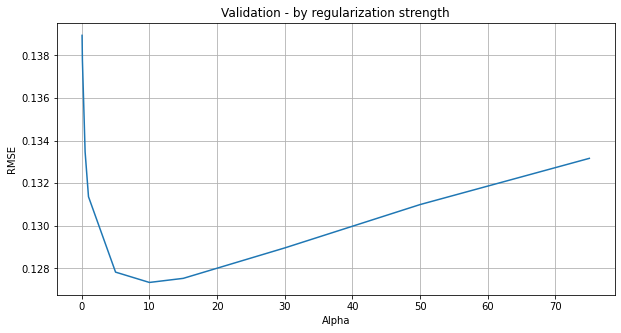

In [16]:
from sklearn.linear_model import Ridge

# 建立Ridge迴歸模型
model_ridge = Ridge()

# 準備10種L2常規化強度
alphas = [0.05, 0.1, 0.5, 1, 5, 10, 15, 30, 50, 75]
# 在各個常規化的強度中執行Ridge迴歸
# 將資料分割為5個部分進行交叉驗證，求出RMSE、並取得該平均值
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

# 將cv_ridge 轉換為 Series object
cv_ridge = pd.Series(cv_ridge, index = alphas)
# 輸出分數
print('Ridge RMSE loss:')
print(cv_ridge, '\n')
# 輸出分數的平均
print('Ridge RMSE loss Mean:')
print(cv_ridge.mean())

# 將各個常規化的強度製作為圖表
plt.figure(figsize=(10, 5)) # 描繪區域的尺寸
plt.plot(cv_ridge) # 將cv_ridge描繪為圖形
plt.grid() # 顯示格線
plt.title('Validation - by regularization strength')
plt.xlabel('Alpha')
plt.ylabel('RMSE')
plt.show()

In [17]:
from sklearn.linear_model import LassoCV

# 使用LASSO迴歸模型進行推斷
# 使用4種L1範數進行嘗試
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)

print('Lasso regression RMSE loss:')                    # 透過交叉驗證
print(rmse_cv(model_lasso))                             # 輸出RMSE

print('Average loss:', rmse_cv(model_lasso).mean())     # 輸出RMSE的平均
print('Minimum loss:', rmse_cv(model_lasso).min())      # 輸出RMSE的最小值
print('Best alpha :', model_lasso.alpha_)               # 輸出被系統選用的alpha值

Lasso regression RMSE loss:
[0.10330995 0.13147299 0.12552458 0.10530461 0.14723333]
Average loss: 0.12256909294467
Minimum loss: 0.10330995071896426
Best alpha : 0.0005


In [18]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label = y)

# 決策樹深度為3、學習率為 0.1
params = {"max_depth":3, "eta":0.1}
# 使用xgboost模型執行交叉驗證
cross_val = xgb.cv(params,
                   dtrain,
                   num_boost_round=1000,    # 決策樹的數量
                   early_stopping_rounds=50)  # 提前中止的監控次數
cross_val

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,10.380516,0.003151,10.380511,0.007226
1,9.345149,0.002915,9.345143,0.007586
2,8.413392,0.002710,8.413386,0.007926
3,7.574888,0.002511,7.575220,0.007951
4,6.820174,0.002320,6.820488,0.007688
...,...,...,...,...
405,0.040728,0.000315,0.125469,0.013440
406,0.040663,0.000320,0.125464,0.013418
407,0.040607,0.000326,0.125434,0.013416
408,0.040534,0.000332,0.125432,0.013409


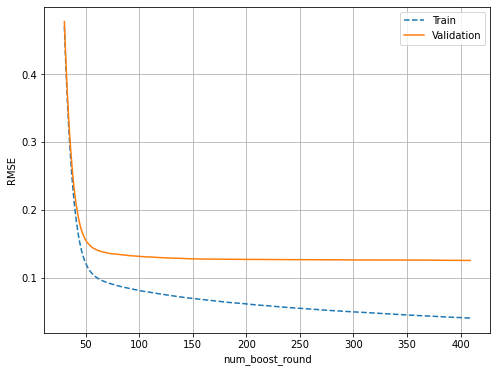

In [19]:
plt.figure(figsize=(8, 6))   # 描繪區域的尺寸
plt.plot(cross_val.loc[30:,["train-rmse-mean"]], linestyle = '--',
         label = 'Train')
plt.plot(cross_val.loc[30:,["test-rmse-mean"]], 
         label = 'Validation')
plt.grid()   # 顯示格線
plt.xlabel('num_boost_round')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [20]:
model_xgb = xgb.XGBRegressor(n_estimators=410,    # 決策樹數量
                             max_depth=3,         # 決策樹深度
                             learning_rate=0.1)   # 學習率 0.1
model_xgb.fit(X_train, y)
print('xgboost RMSE loss:')
print(rmse_cv(model_xgb).mean()) # 透過交叉驗證輸出RMSE的平均

xgboost RMSE loss:
0.12437590040488114


In [21]:
lasso_preds = np.expm1(model_lasso.predict(X_test))
xgb_preds = np.expm1(model_xgb.predict(X_test))


In [22]:
preds = lasso_preds * 0.7 + xgb_preds * 0.3

In [23]:
solution = pd.DataFrame({"id":test.Id, "SalePrice":preds})
solution.to_csv("ensemble_sol.csv", index = False) 